In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import math
import seaborn as sns
import pandas as pd

#Import manifold algorithms
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,Isomap,LocallyLinearEmbedding,SpectralEmbedding, TSNE
import umap

from sklearn.model_selection import KFold
import sklearn.metrics.pairwise as mtr

# import umap
file_name = '/Users/rufusmitchell-heggs/Desktop/Neural manifold Review/data_analysis/Monkey data/trainingData100.mat'
mat = scipy.io.loadmat(file_name)
figDir = "/Users/rufusmitchell-heggs/Desktop/Neural manifold Review/5_Figure"

Plot the individual trajecotires for a subset of the angles.

sub panel of the figure from Krishna

In [ ]:
def OLE(X, Y):
    # Optimal linear estimator - obtain the estimator's weights
    X = np.c_[np.ones((X.shape[0], 1)), X]
    # obtain the estimator
    return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))

def LinRec(f, X, Y):
    # Obtain the prediction on the test data
    X = np.c_[np.ones((X.shape[0], 1)), X]  # append a row of ones to the input
    Rec = np.dot(X, f)
    # Evaluate the prediction
    RMSE = np.mean(np.sqrt((Y - Rec)**2))
    R = np.corrcoef(Y, Rec)[0, 1]
    return Rec, RMSE, R

def new_LLE_pts(M, M_LLE, k, x, lam=1):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_LLE: a rank [m * N] matrixwhich is the output of LLE(M,k,m)
       - k: the number of neighbors used to produce M_LLE
       - x: a length d data vector OR a rank [d * Nx] array
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are correct
    d,N = M.shape
    m,N2 = M_LLE.shape
    assert N==N2
    Nx = x.shape[1]
    W = np.zeros([Nx,N])

    for i in range(x.shape[1]):
        #  find k nearest neighbors
        M_xi = M-np.atleast_2d(x[:,i]).T
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1]
        
        #compute covariance matrix of distances
        M_xi = M_xi[:,nbrs]
        Q = M_xi.T @ M_xi

        #singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        #Covariance matrix may be nearly singular:
        # add a diagonal correction to prevent numerical errors
        Q += (lam) * np.identity(Q.shape[0])

        #solve for weight
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        W[i,nbrs] = w
    
    return np.array( M_LLE  * np.matrix(W).T ).T

def rec_embd_lle(M_embd, M, k, lam=1):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_embd: a rank [m * N] matrix which is the output of LLE(M,k,m)
       - k: the number of neighbors to use for the reconstruction
       - lam = regularisation parameter
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are of the right dimansions and convert to np.matrix
    M = np.matrix(M)
    M_embd = np.matrix(M_embd)
    d,N = M.shape
    m,N2 = M_embd.shape
    assert N==N2    

    # initialise matrix to store eigenvalues
    min_dim = np.min([m,k])
    eig = np.zeros((N,min_dim))
    W = np.matrix(np.zeros((N,N)))

    for i in range(M.shape[1]):
        # find k nearest neighbors
        M_xi = np.array(M_embd - M_embd[:,i])
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1] # exclude self-neighbour
        
        # compute covariance matrix of distances
        M_xi = np.matrix(M_xi[:,nbrs])
        Q = M_xi.T * M_xi

        # singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        # Covariance matrix may be nearly singular:
        # add a diagonal correction to prevent numerical errors
        # correction is equal to the sum of the (d-m) unused variances
        # (as in deRidder & Duin)
        r = np.sum(sig2[m:])
        Q += (lam) * np.identity(Q.shape[0])
        # Note that Roewis et al instead uses "a correction that 
        #   is small compared to the trace":
        #r = 0.001 * float(Q.trace())
        
        # solve for weights
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        W[i,nbrs] = w
        sig2 /= sig2.sum()
        eig[i,:] = sig2
#         print('x[%i]: variance conserved: %.2f' % (i, sig2[:m].sum()))
        
    # multiply weights by projections of neighbors to get y
    M_rec = np.array(M * np.matrix(W).T).T
    
    return M_rec, eig

def centre_scale(x):
    xm = x - np.mean(x)
    return xm/np.max(xm)

def cmdscale(D):
    """                                                                                       
    Classical multidimensional scaling (MDS)                                                  

    Parameters                                                                                
    ----------                                                                                
    D : (n, n) array                                                                          
        Symmetric distance matrix.                                                            

    Returns                                                                                   
    -------                                                                                   
    Y : (n, p) array                                                                          
        Configuration matrix. Each column represents a dimension. Only the                    
        p dimensions corresponding to positive eigenvalues of B are returned.                 
        Note that each dimension is only determined up to an overall sign,                    
        corresponding to a reflection.                                                        

    e : (n,) array                                                                            
        Eigenvalues of B.                                                                     

    """
    # Number of points                                                                        
    n = len(D)
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
    # Sort by eigenvalue in descending order                                                  
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals>0)
    L = np.diag(np.sqrt(evals[w]))
    V = evecs[:,w]
    Y = V.dot(L)

    return Y, evals

def myround(x, base=10):
    return base * round(x/base)

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def event_rate(event_traces, window = 20):
    event_rates = []
    for events in event_traces:
        wdw = window # 20 = window size of 1 second
        t_0 = 0; t_1 = wdw
        e_rate = np.array([])
        while t_1 <= len(events):
            e_rate = np.append(e_rate, sum(events[t_0:t_1])/wdw)
            t_0+=wdw; t_1+=wdw
            
        e_rate = e_rate/max(e_rate)
        event_rates.append(e_rate)
    return np.array(event_rates)

def behav_vector_binning(behav_vector, window=15):
    wdw = window
    bv_binned = np.array([])
    t_0 = 0; t_1 = wdw
    while t_1 <= len(behav_vector):
        bv_binned = np.append(bv_binned,stats.mode(behav_vector[t_0:t_1])[0])
        t_0+=wdw; t_1+=wdw
    return bv_binned

In [ ]:
colors = ["Red", "Blue", "Green", "Orange", "Yellow", "Gray", "pink", "Purple"]

target_names = ["30/180π", "70/180π", "110/180π", "150/180π", 
               "190/180π","230/180π", "310/180π", "350/180π"]

colb = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']


In [ ]:
#Read in Monkey data 300ms at centre reach and 100ms at end
dataset = mat['trial'] #Entire dataset
p_angles = [30, 70, 110, 150, 190, 230, 270, 350]
spikes = []; angles = []; handpos = []
for trial in dataset:
    for i, angle in enumerate(trial):
        x1,y1 = [-10, -7]
        x2 = np.mean(angle[2][0][-10:])
        y2 = np.mean(angle[2][1][-10:])
        th = min(p_angles, key=lambda x:abs(x-myround(angle_between((y2,x2), (y1,x1)))))
        angles += [th]*len(angle[1][0][300:-100])
        handpos.append(angle[2][:,300:-100])
        spikes.append(angle[1][:,300:-100])
        
dff = np.concatenate(spikes, axis=1)
handpos = np.concatenate(handpos, axis=1).T
angles = np.array(angles)

# initialise dict to store decoding scores
RMSE = {}; R = {}
var_expl = {}; var_expl_embd = {}
rec_err = {}; rec_corr = {}
var_svd = {}; H = {}

(-100, 100)

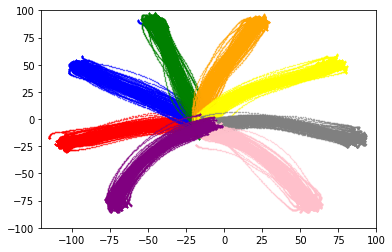

In [5]:
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(handpos[angles == i,0], handpos[angles == i,1], 
                      c=color, label=target_name, alpha=.7, s=0.2)
plt.xlim(-120,100)
plt.ylim(-100,100)

In [6]:
#Downsample to 10 HZ
dff = event_rate(dff, 100)
angles = behav_vector_binning(angles, 100)

In [7]:
TYP = 0
K_lle = 10
LAMBDA = 1

# obtain cosine distance matrix
if TYP: down = 3 # downsampling factor for speeding up calculations
else: down = 1 # no downsampling foir sim data

X = dff[:,::down].T
theta = angles[::down]
D = cosine_distances(X)
ds_plt = 1

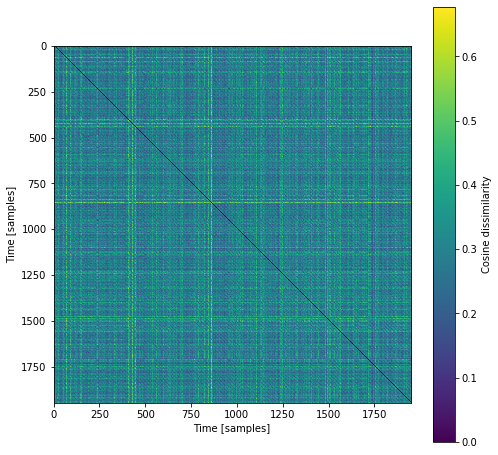

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(D,cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Cosine dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');

# PCA

In [95]:
from sklearn.decomposition import PCA
DIMS = 5
pca = PCA(n_components=DIMS)
x_embd = pca.fit_transform(X)
x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
AXIS_LIM = np.max(x_embd)

<IPython.core.display.Javascript object>


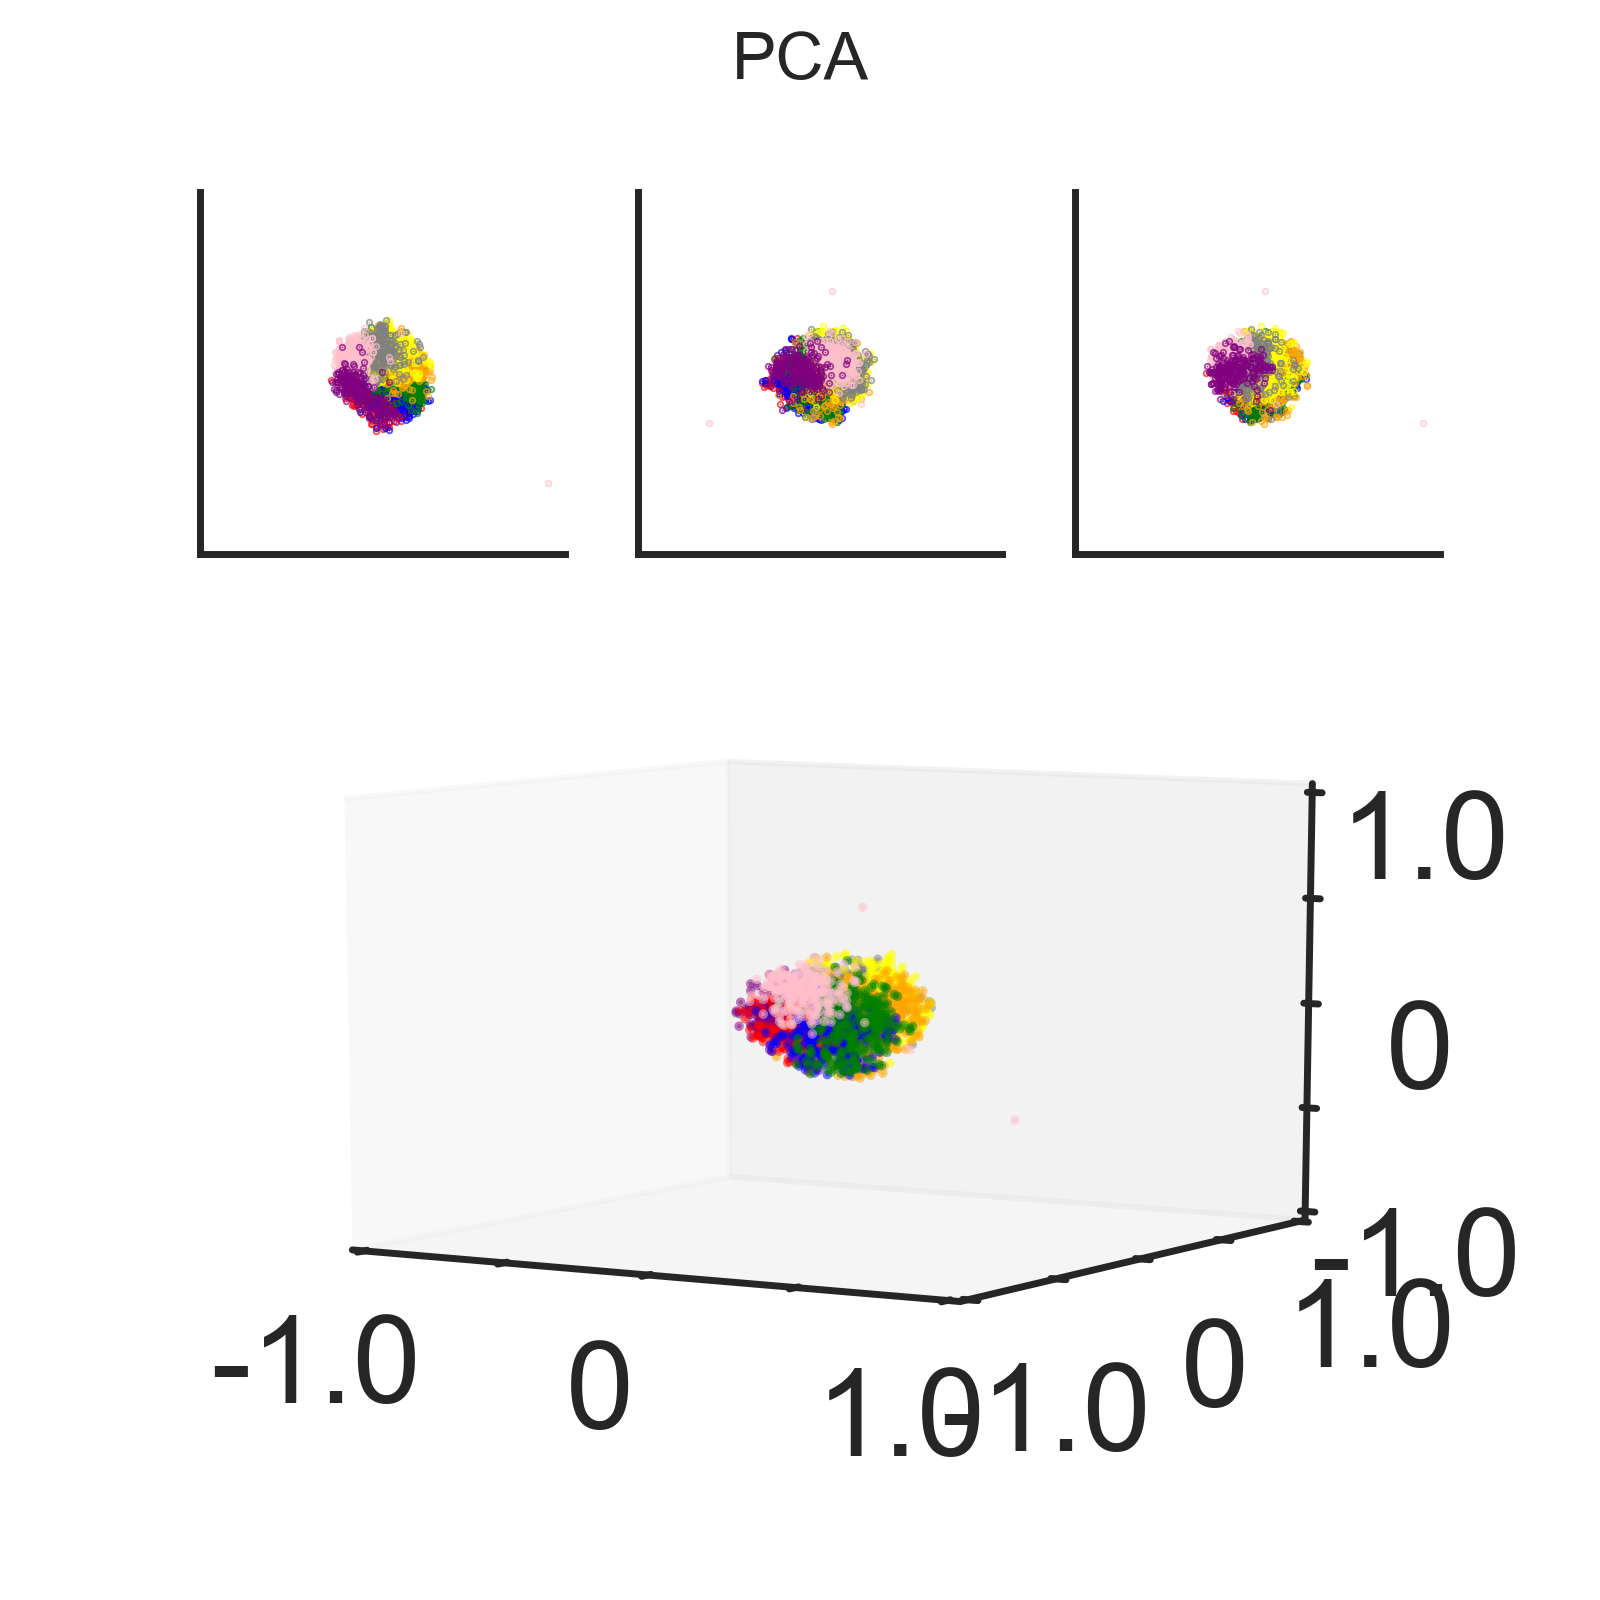

In [158]:
%matplotlib notebook
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('PCA')

# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=0.5, s=0.5)

# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/PCA_'+'Monkey'+'.png')
    plt.savefig(figDir+'/PCA_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/PCA_'+'Monkey'+'.png')
    plt.savefig(figDir+'/PCA_'+'Monkey'+'.svg')

In [66]:
### OLE  decoding
EMBD = 'PCA'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [67]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


## CMDSCALE (classic  MDS)

In [97]:
# fit embedding
x_embd,eig_mds_dff = cmdscale(D)
x_embd = x_embd / np.max(x_embd)
AXIS_LIM = np.max(x_embd)

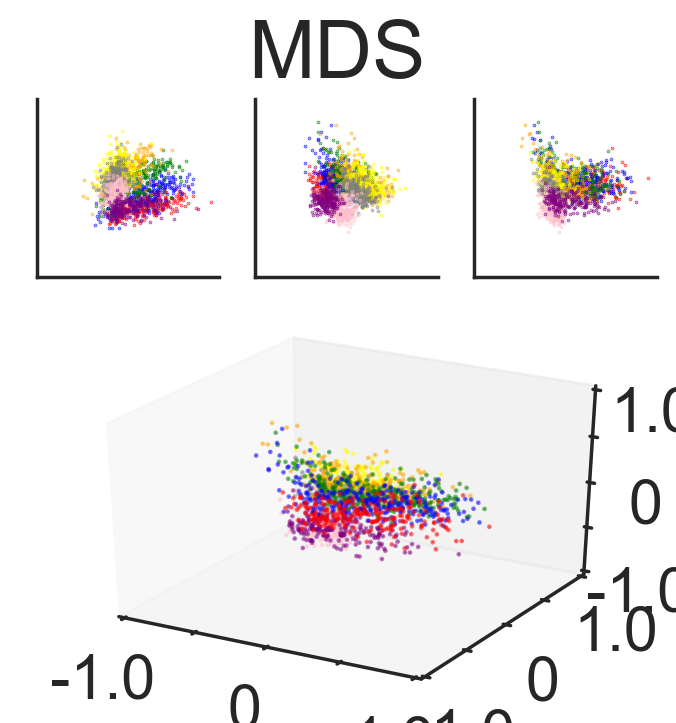

In [98]:
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('MDS')

# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=0.5, s=0.5)

# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/MDS_'+'Monkey'+'.png')
    plt.savefig(figDir+'/MDS_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/MDS_'+'Monkey'+'.png')
    plt.savefig(figDir+'/MDS_'+'Monkey'+'.svg')

In [70]:
### OLE  decoding
EMBD = 'tSNE'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [71]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


## ISOMAP

In [99]:
# fit embedding
COS = 1 # set to 1 for embedding the cosine distance matrix
if COS:
    if TYP: isomap = Isomap(n_components=DIMS, n_neighbors=40)
    else: isomap = Isomap(n_components=DIMS, n_neighbors=10)
    x_embd = isomap.fit_transform(D)
else:
    if TYP: isomap = Isomap(n_components=DIMS, n_neighbors=40, metric='minkowski')
    else: isomap = Isomap(n_components=DIMS, n_neighbors=10, metric='minkowski')
    x_embd = isomap.fit_transform(X)
x_embd = x_embd / np.max(x_embd)
AXIS_LIM = np.max(x_embd)

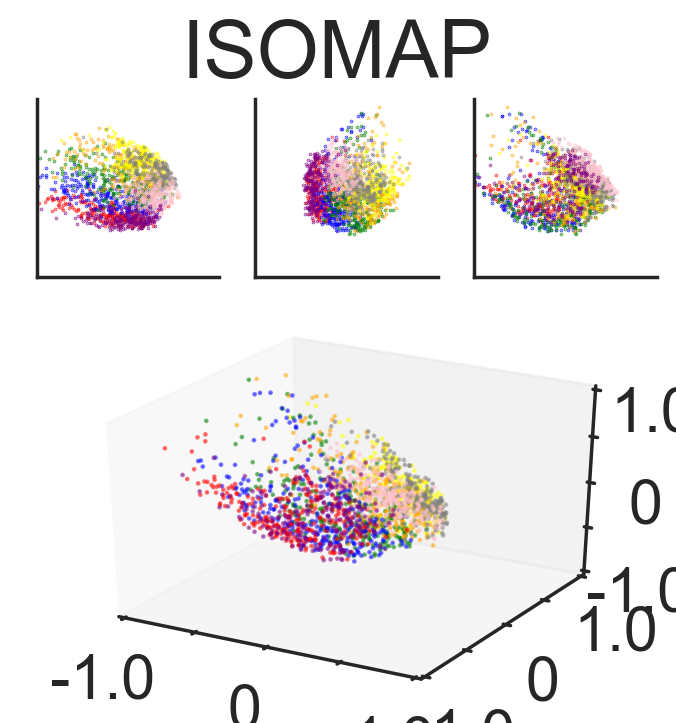

In [100]:
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('ISOMAP')

# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=0.5, s=0.5)

# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/ISOMAP_'+'Monkey'+'.png')
    plt.savefig(figDir+'/ISOMAP_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/ISOMAP_'+'Monkey'+'.png')
    plt.savefig(figDir+'/ISOMAP_'+'Monkey'+'.svg')

In [74]:
### OLE  decoding
EMBD = 'ISOMAP'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [75]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


## LLE

In [147]:
# fit embedding
if TYP: 
    lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=60, method='modified')
    x_embd = lle.fit_transform(D)
else:
    lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=10, method='modified')
    x_embd = lle.fit_transform(X)
x_embd = centre_scale(x_embd)
AXIS_LIM = np.max(x_embd)

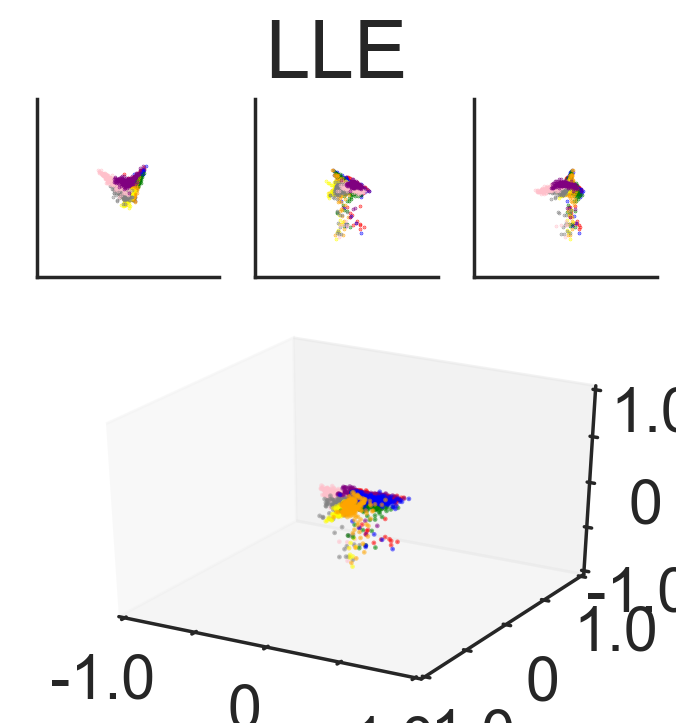

In [148]:
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('LLE')

# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=0.5, s=0.5)

# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/LLE_'+'Monkey'+'.png')
    plt.savefig(figDir+'/LLE_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/LLE_'+'Monkey'+'.png')
    plt.savefig(figDir+'/LLE_'+'Monkey'+'.svg')

In [78]:
### OLE  decoding
EMBD = 'LLE'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [79]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


## Laplacian eigenmaps (Spectral embedding)

In [103]:
# fit embedding
if TYP:
    SE = SpectralEmbedding(n_components=DIMS, affinity='nearest_neighbors', n_neighbors=40)
    x_embd = SE.fit_transform(D)
else:
    SE = SpectralEmbedding(n_components=DIMS, affinity='nearest_neighbors', n_neighbors=10)
    x_embd = SE.fit_transform(X)
x_embd = x_embd / np.max(x_embd)
AXIS_LIM = np.max(x_embd)

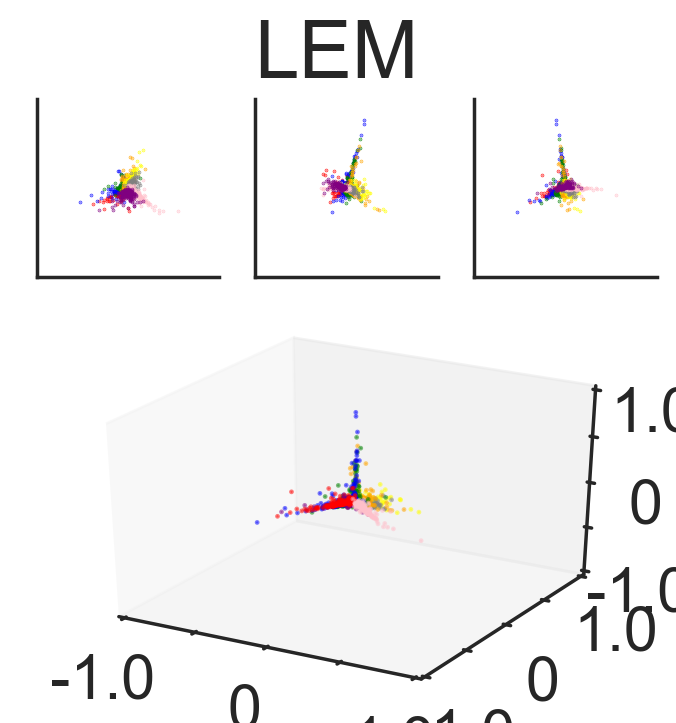

In [104]:
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('LEM')

# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=0.5, s=0.5)

# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/LEM_'+'Monkey'+'.png')
    plt.savefig(figDir+'/LEM_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/LEM_'+'Monkey'+'.png')
    plt.savefig(figDir+'/LEM_'+'Monkey'+'.svg')

In [82]:
### OLE  decoding
EMBD = 'LEM'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [83]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


## GPFA

In [84]:
#DATA NEEDED

# t-SNE

In [156]:
# fit embedding
if TYP:
    SE = TSNE(n_components=3, metric='cosine', perplexity=90, random_state=42)
    x_embd = SE.fit_transform(X)
else:
    SE = TSNE(n_components=3, metric='cosine', perplexity=30, random_state=42)
    x_embd = SE.fit_transform(X)
# x_embd = x_embd / np.max(x_embd)
x_embd = centre_scale(x_embd)

AXIS_LIM = np.max(x_embd)

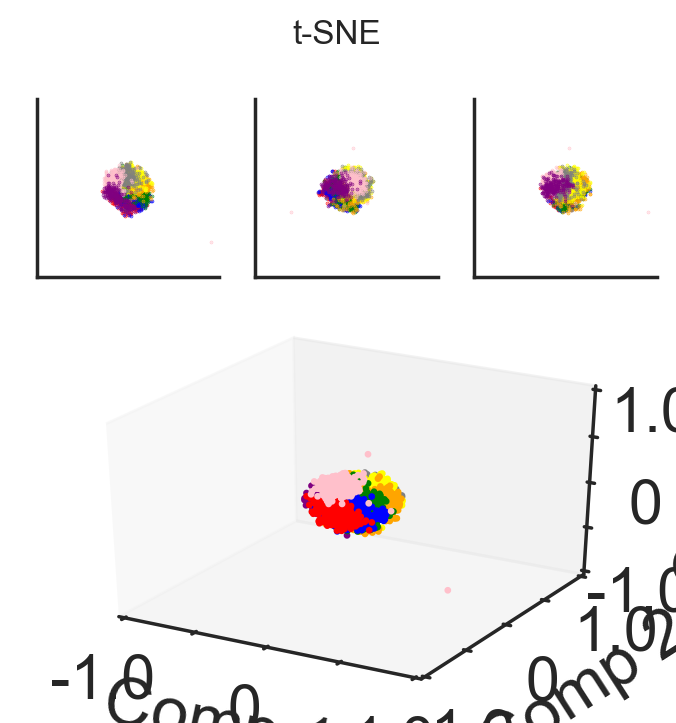

In [157]:
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('t-SNE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=1, s=2)

# cbar.set_label('Angular position')
ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/tSNE_'+'Monkey'+'.png')
    plt.savefig(figDir+'/tSNE_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/tSNE_'+'Monkey'+'.png')
    plt.savefig(figDir+'/tSNE_'+'Monkey'+'.svg')

In [87]:
### OLE  decoding
EMBD = 'tSNE'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [88]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


## UMAP

In [107]:
from sklearn.preprocessing import StandardScaler
# fit embedding
if TYP:
    SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=160, random_state=42)
    x_embd = SE.fit_transform(X)
else:
    SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=20, random_state=4)
    x_embd = SE.fit_transform(X)
x_embd = centre_scale(x_embd)
AXIS_LIM = np.max(x_embd)

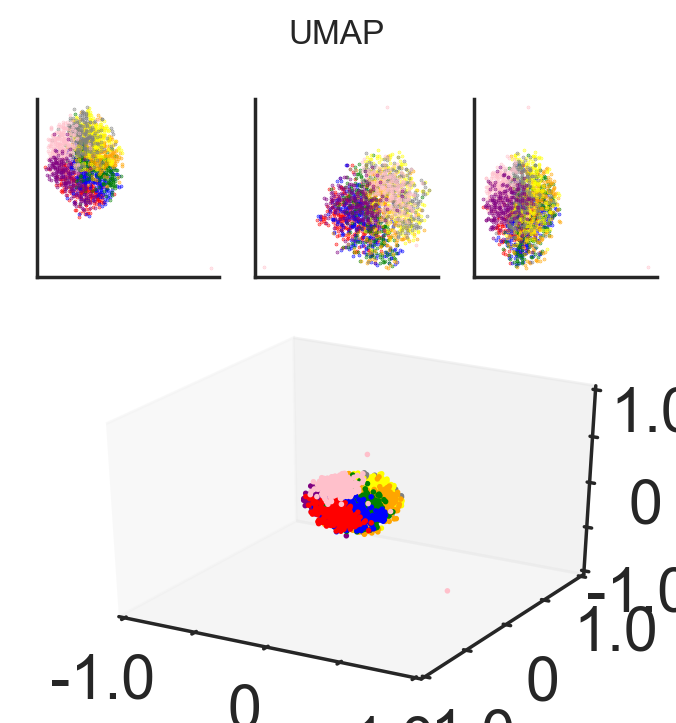

In [154]:
fig = plt.figure(figsize=(4,4), dpi=200)
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('UMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
for color, i, target_name in zip(colors, p_angles, target_names):
    scat = ax.scatter(x_embd[theta == i,0], x_embd[theta == i,1], x_embd[theta == i,2], 
                      c=color, label=target_name, alpha=1, s=1)

# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
ax.grid(False)

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,1], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,1], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
for color, i, target_name in zip(colors, p_angles, target_names):
    plt.scatter(x_embd[theta == i,0], x_embd[theta == i,2], c=color, label=target_name, alpha=.7, s=0.1)
# ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#saving
if TYP:
    plt.savefig(figDir+'/UMAP_'+'Monkey'+'.png')
    plt.savefig(figDir+'/UMAP_'+'Monkey'+'.svg')
else:
    plt.savefig(figDir+'/UMAP_'+'Monkey'+'.png')
    plt.savefig(figDir+'/UMAP_'+'Monkey'+'.svg')

In [91]:
### OLE  decoding
EMBD = 'UMAP'
N = DIMS
cv = 10
Y = theta # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [92]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.
.
.
.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


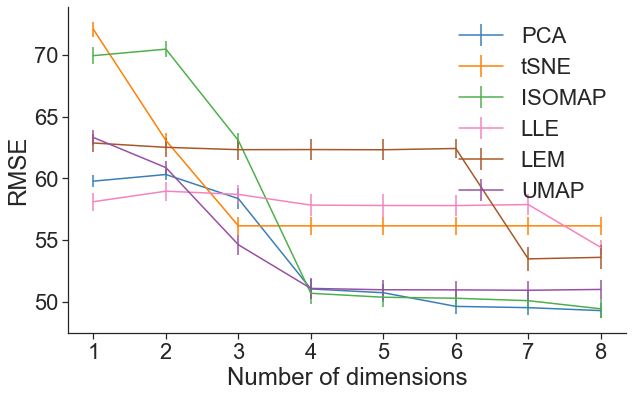

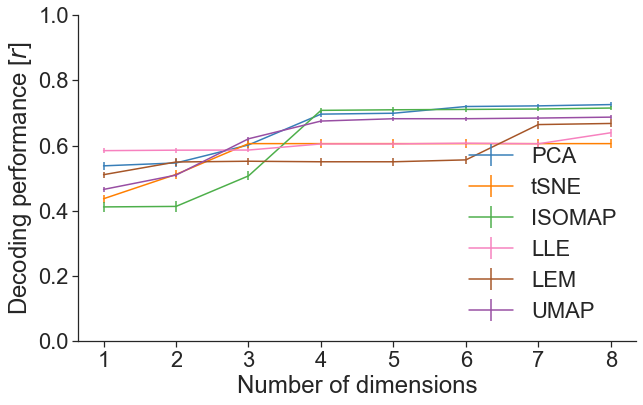

In [93]:
sns.set(style='ticks', font_scale=2)
plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(RMSE[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(RMSE[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False, loc=1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('RMSE')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
plt.savefig(figDir+'/decode_rmseErr_Monkey.svg')
plt.savefig(figDir+'/decode_rmseErr_Monkey.png')

plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(R[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(R[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Decoding performance [$r$]')
plt.xlabel('Number of dimensions')
plt.legend(frameon=False, loc="Best")
sns.despine()
plt.savefig(figDir+'/decode_corrErr_Monkey.svg')
plt.savefig(figDir+'/decode_corrErr_Monkey.png')

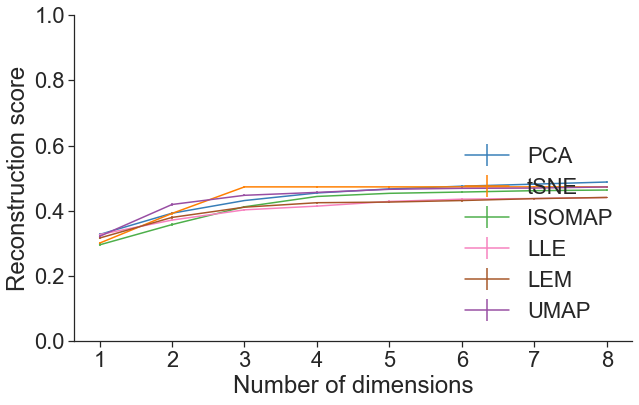

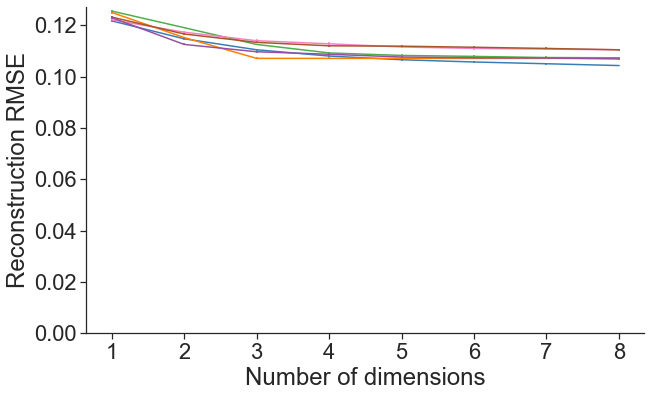

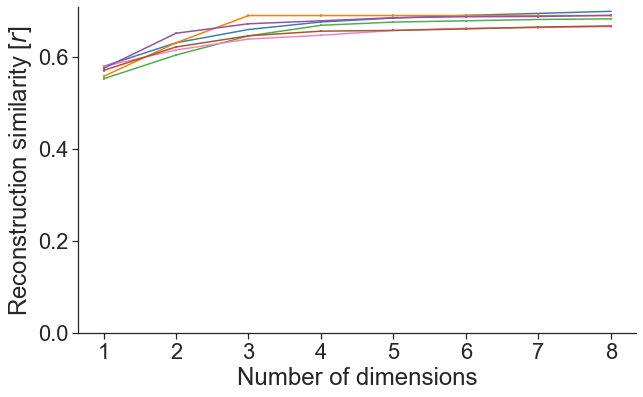

In [94]:
keys = list(var_expl.keys())

# Non-linear  variance explained
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(var_expl[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(var_expl[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False,loc=4)
if TYP: plt.ylim(0,.6)
else: plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Reconstruction score')
plt.xlabel('Number of dimensions')
sns.despine()

#saving
plt.savefig(figDir+'/var_expl_Monkey.svg')
plt.savefig(figDir+'/var_expl_Monkey.png')

# Reconstuction error
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_err[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_err[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction RMSE')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
plt.savefig(figDir+'/rec_err_Monkey.svg')
plt.savefig(figDir+'/rec_err_Monkey.png')
    
# Reconstuction correlation
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_corr[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_corr[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction similarity [$r$]')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
plt.savefig(figDir+'/rec_corr_Monkey.svg')
plt.savefig(figDir+'/rec_corr_Monkey.png')